In [1]:
import netsim_summariser as summ

In [2]:
reload(summ)

<module 'netsim_summariser' from '/home/davidwu/REPOS/echidna_network/netsim_summariser.py'>

In [37]:
import itertools
import numpy as np
from scipy import stats, special
import polars as pl
from matplotlib import pyplot as plt, cycler
import seaborn as sns
from pathlib import Path

sns.set()

In [4]:
RECOMPUTE_METRICS = False

In [5]:
simulation_archives = {
    'temporal': './zero_sims/temporal/sim_all_30s.h5',
    'static': './zero_sims/static/sim_all_30s.h5',
    'snapshot': './zero_sims/snapshot/sims_with_30seeds_pseudocap.h5',
    'naive_static': './zero_sims/naive_static/sim_all_30s.h5',
}

processed_results = {}

for label, archive in simulation_archives.items():
    if RECOMPUTE_METRICS:
        summariser = summ.Summariser(archive)
        result_df = summariser.metrics(ncpus=6, no_move=True, drop=[]).add_extent(30)
        result_df.write_parquet(Path(archive).with_name('metrics_30s.parquet'))
        processed_results[label] = result_df
    else:
        processed_results[label] = pl.read_parquet(Path(archive).with_name('metrics_30s.parquet'))


In [43]:
def compute_median_extent(df: pl.DataFrame):
    return df.group_by('seed').median().select('seed', 'extent')

def plot_median_extent(df: pl.DataFrame):
    median_extent = compute_median_extent(df)
    ordering = median_extent.sort('extent', descending=True).select('seed').to_series().to_list()

    fig, ax = plt.subplots(figsize=(18, 6))
    sns.boxplot(
        df.select('seed', 'extent'),
        x='seed',
        y='extent',
        order=ordering,
        orient='v',
        ax=ax
    )

    return (median_extent, ordering, fig, ax)

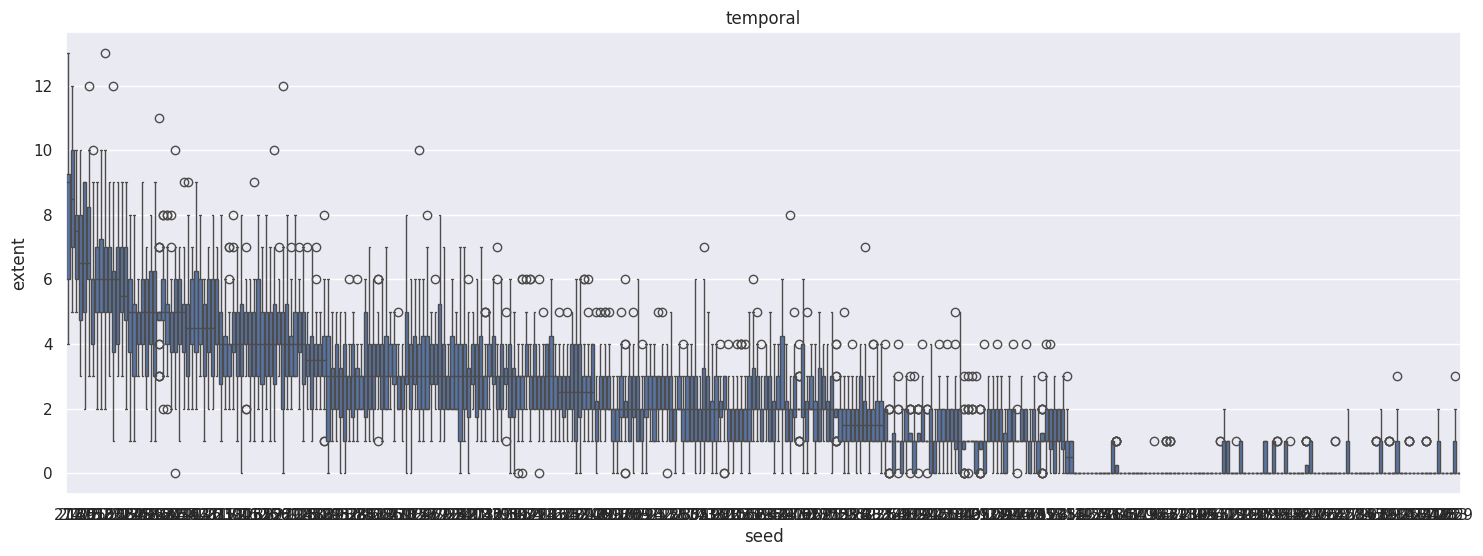

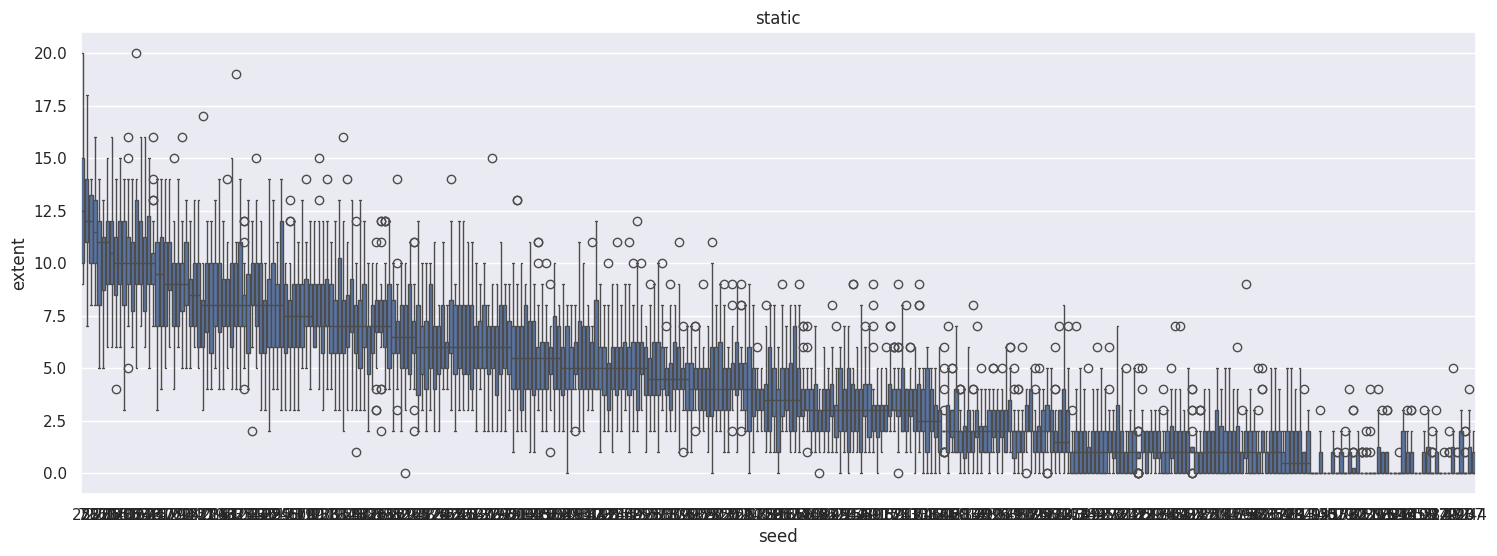

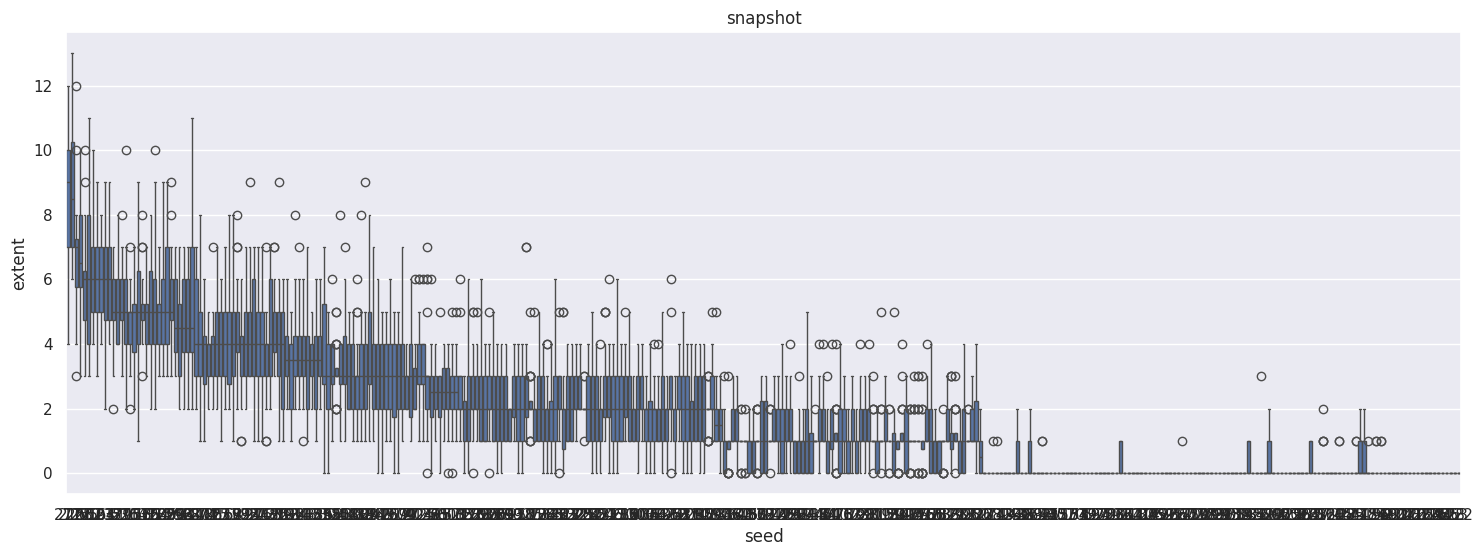

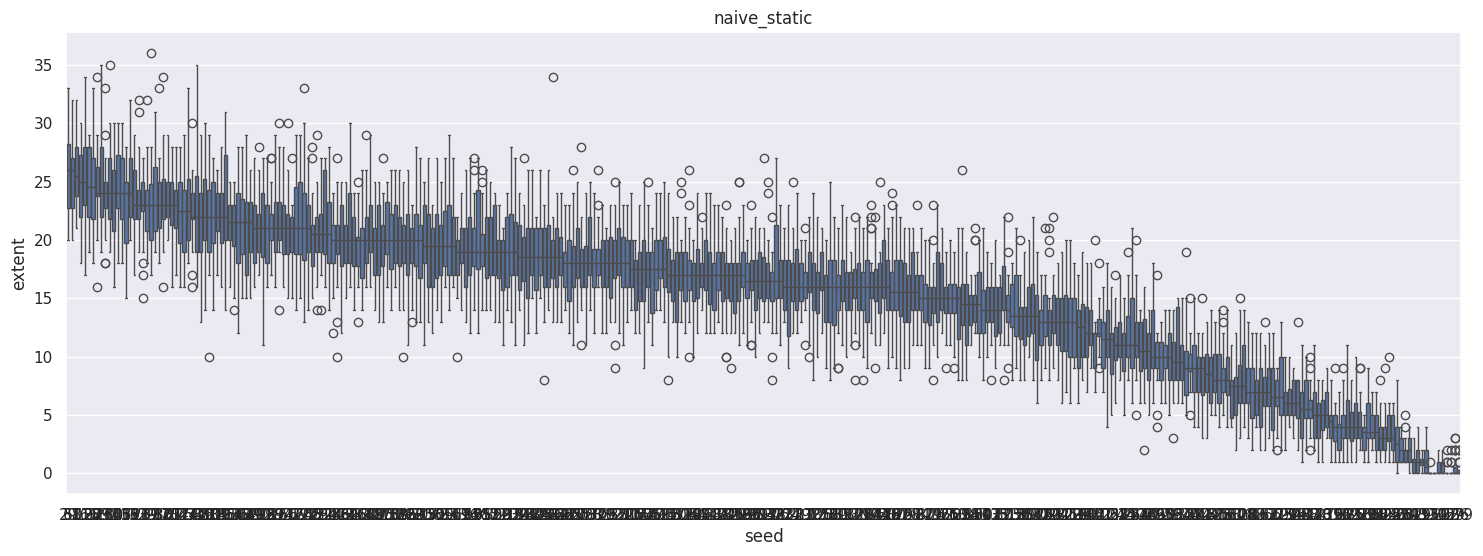

In [44]:
for k, df in processed_results.items():
    _, _, fig, ax = plot_median_extent(df)
    ax.set_title(k)

In [45]:
combined_median_df = pl.concat(
    [compute_median_extent(df).with_columns(pl.lit(label).alias('simulation'))
     for label, df in processed_results.items()]
)

combined_median_sort = combined_median_df.group_by('seed').median().select('seed', 'extent').sort('extent', descending=True).select('seed').with_row_index('sorted_seed')

combined_median_df = combined_median_df.join(combined_median_sort, on='seed')

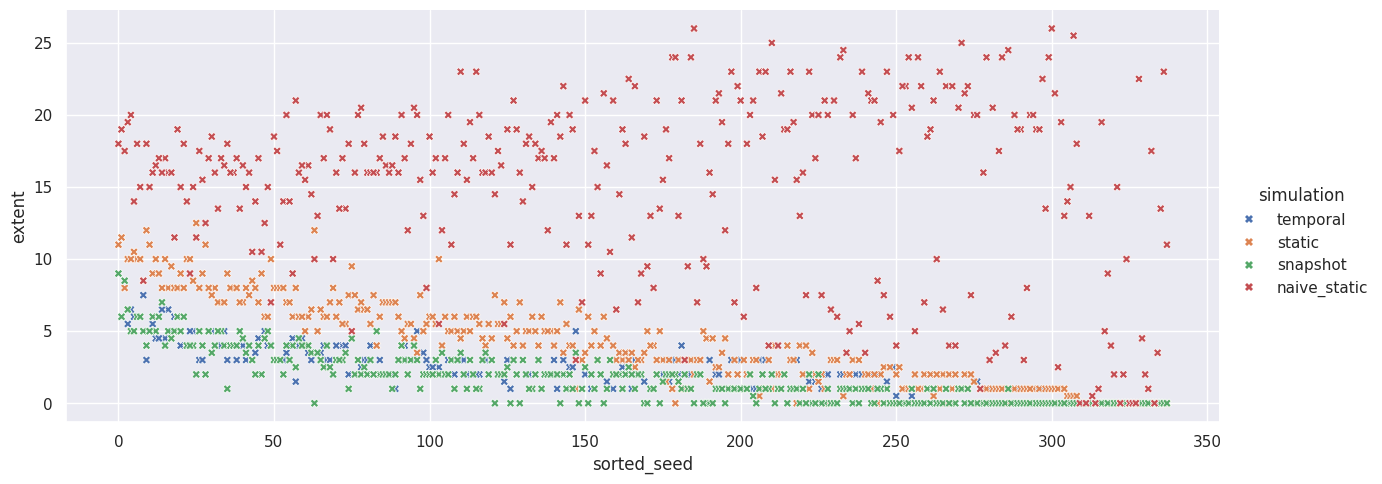

In [46]:
sns.relplot(
    combined_median_df,
    x='sorted_seed',
    y='extent',
    hue='simulation',
    marker='X',
    aspect=2.5,
)#.savefig("zero_extent_median_comparison.png", dpi=200)


In [47]:
combined_all_df = pl.concat(
    [df.select('seed', 'extent').with_columns(pl.lit(label).alias('simulation'), pl.col('extent').cast(pl.Int64))
     for label, df in processed_results.items()]
)

combined_sort_order = combined_all_df.group_by('seed').median().select('seed', 'extent').sort('extent', descending=True).select('seed').with_row_index('sorted_seed')

combined_all_df = combined_all_df.join(combined_sort_order, on='seed')

<Axes: ylabel='extent'>

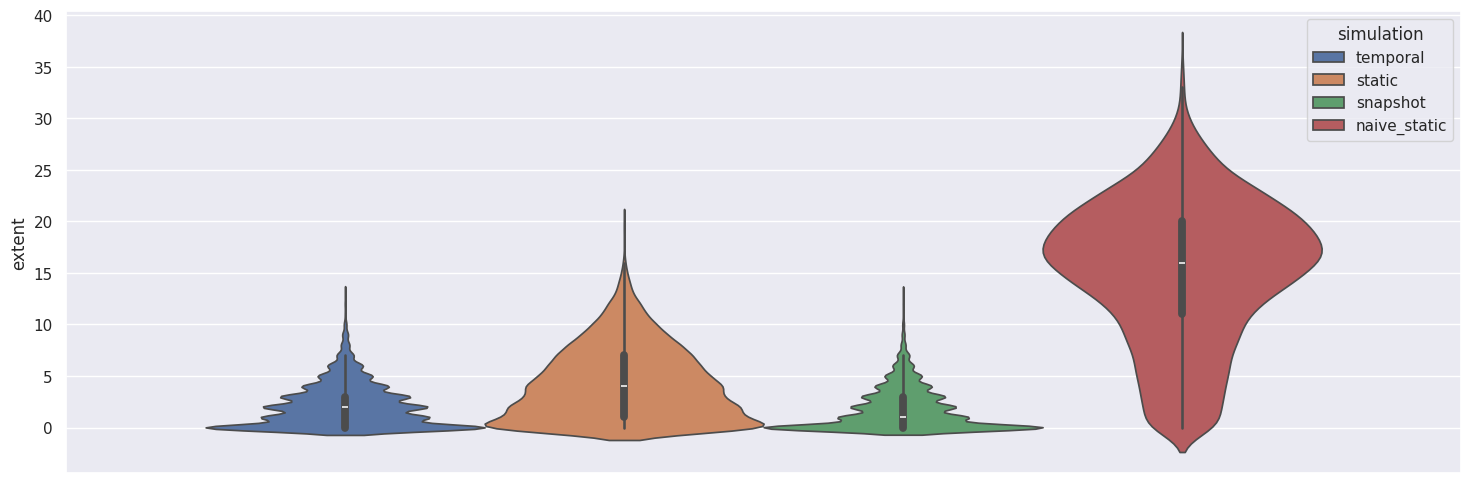

In [48]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.violinplot(
    combined_all_df,
    # x='sorted_seed',
    y='extent',
    hue='simulation',
    # log_scale=(True),
    # kind='box',
    # marker='.',
    # alpha=0.6,
    # aspect=2.5,
    ax=ax,
)
# ax.set_ylabel('extent + 1')
# ).savefig("zero_extent_all_comparison.png", dpi=200)
# fig.savefig('zero_extent_all_comparison.png', dpi=200)

In [50]:
paired_median_df = combined_median_df.pivot("simulation", index="sorted_seed", values="extent").fill_null(0.0)

In [51]:
for p1, p2 in itertools.combinations(processed_results.keys(), 2):
    print(p1, 'vs', p2)
    print(stats.ttest_rel(paired_median_df[p1], paired_median_df[p2], alternative='two-sided'))

temporal vs static
TtestResult(statistic=-15.489888425954147, pvalue=3.034498814730878e-41, df=337)
temporal vs snapshot
TtestResult(statistic=7.433977467714621, pvalue=8.78103063275145e-13, df=337)
temporal vs naive_static
TtestResult(statistic=-38.78359649817265, pvalue=2.6232387457627126e-126, df=337)
static vs snapshot
TtestResult(statistic=19.199042757609984, pvalue=5.021375472553308e-56, df=337)
static vs naive_static
TtestResult(statistic=-29.907281994141915, pvalue=7.5410014888856e-97, df=337)
snapshot vs naive_static
TtestResult(statistic=-39.05598784823633, pvalue=3.805232700597528e-127, df=337)


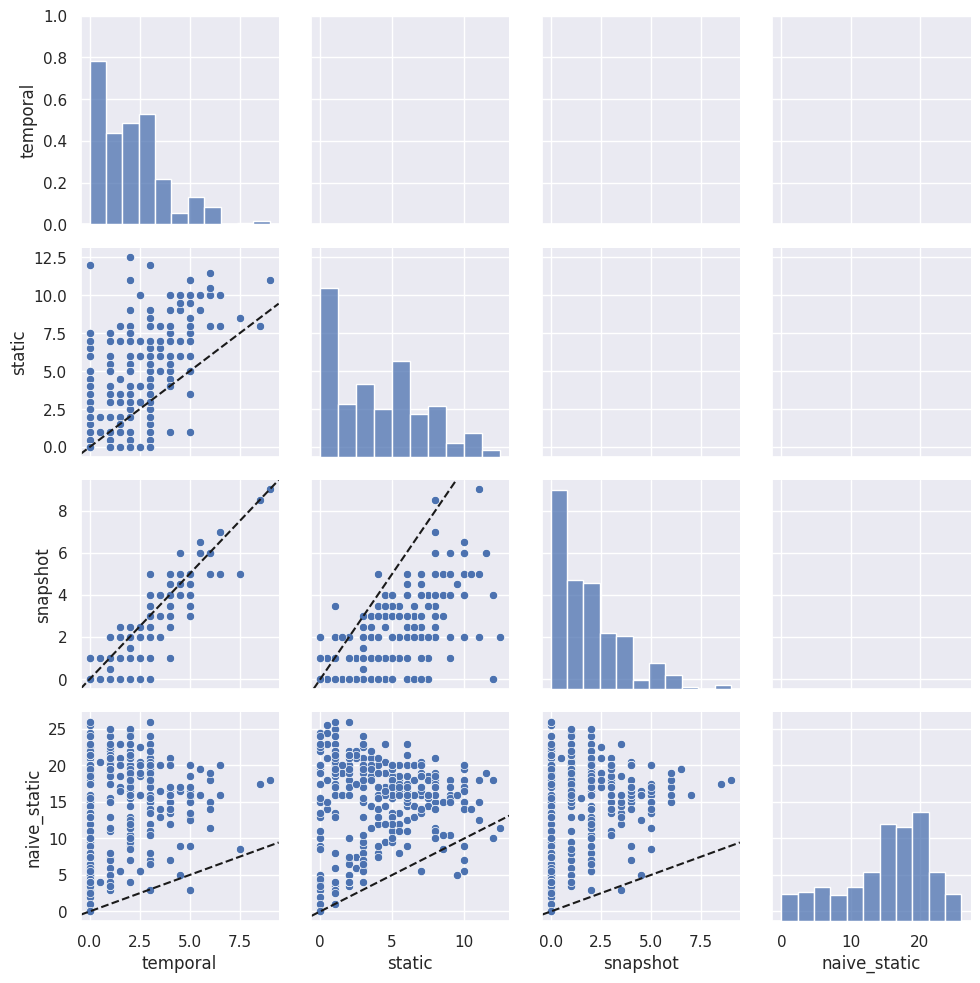

In [52]:
ppl = sns.PairGrid(paired_median_df.to_pandas(), vars=list(processed_results.keys()))
ppl.map_lower(sns.scatterplot)
ppl.map_diag(sns.histplot)
# ppl.map_upper(sns.scatterplot)
ppl.map_lower(lambda *a, **k: plt.axline((0,0), slope=1, linestyle='dashed', color='k'))
# ppl.savefig('zero_median_extent_pairedplot.png', dpi=200)

In [54]:
def extract_reappearance_time(df):

    reappearances = df.select(
        pl.col('seed'),
        pl.concat_list(pl.selectors.starts_with('hitting_time'))
        .list.eval(pl.element().filter(pl.element().is_not_null()).sort(), parallel=True)
        .list.get(1, null_on_oob=True)
        .alias('reappearance_time')
    )

    return reappearances

def get_sort_order(df, order='seed', by='reappearance_time'):
    return df.group_by(order).median().sort(by, descending=True).select(order).to_series().to_list()


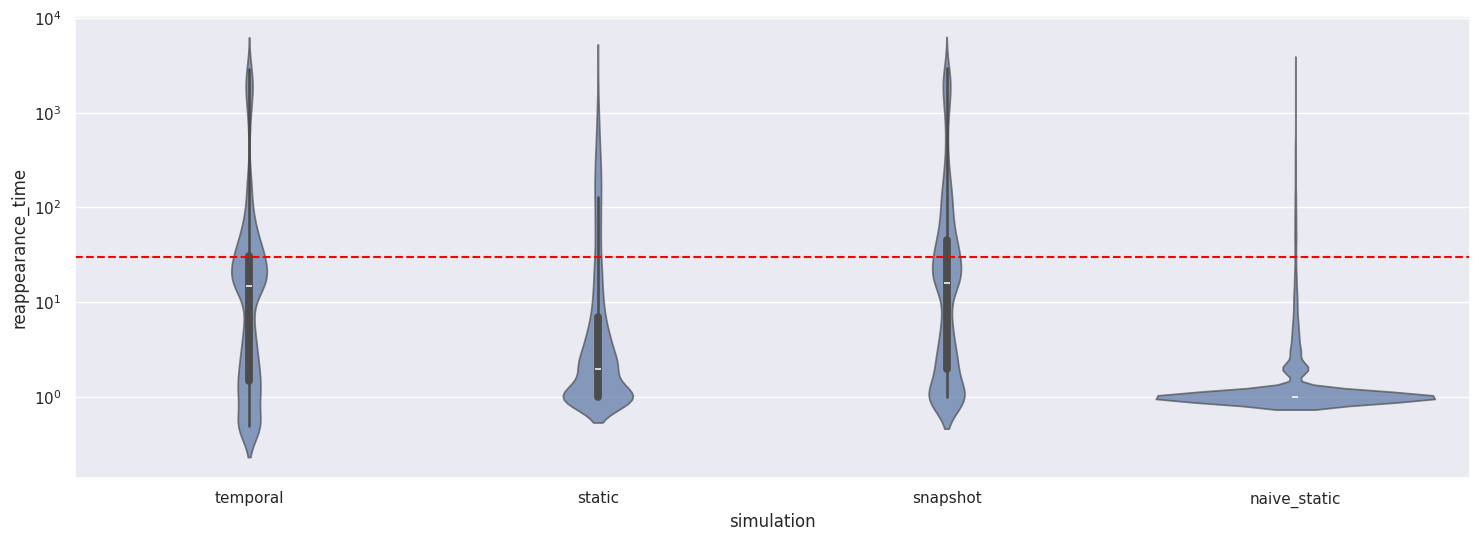

In [55]:
fig, ax = plt.subplots(figsize=(18, 6))

combined_reapp = pl.concat(
    [extract_reappearance_time(df).with_columns(
        pl.lit(label).alias('simulation'), 
        (1.0 / pl.col('reappearance_time')).alias('reappearance_rate'),
    )
     for label, df in processed_results.items()
    ]
)


reapp_order = get_sort_order(combined_reapp, by='reappearance_rate')

sns.violinplot(combined_reapp, y='reappearance_time', x='simulation',  orient='v', ax=ax, log_scale=(False, True), alpha=0.7,)
plt.axhline(30, color='red', linestyle='dashed')
# fig.savefig('zero_reappearance_time.png', dpi=200)


In [71]:
comparative_results = dict()
if RECOMPUTE_METRICS:
# if True:
    for pair in itertools.combinations(processed_results.keys(), 2):
    
        paired_comparison = summ.hitting_time_comparison(*(processed_results[k] for k in pair))
        pair_name = '_x_'.join(pair)
        paired_comparison.write_parquet(f"./zero_sims/comparisons/{pair_name}.30s.parquet")
        
        comparative_results[pair] = paired_comparison
        comparative_results[tuple(reversed(pair))] = paired_comparison.with_columns(-pl.col('statistic'))
else:
    for comp_file in Path("./zero_sims/comparisons/").glob("*.30s.parquet"):
        pair = tuple(comp_file.stem.rstrip('.30s').split('_x_'))
        paired_comparison = pl.read_parquet(comp_file)
        comparative_results[pair] = paired_comparison
        comparative_results[tuple(reversed(pair))] = paired_comparison.with_columns(-pl.col('statistic'))

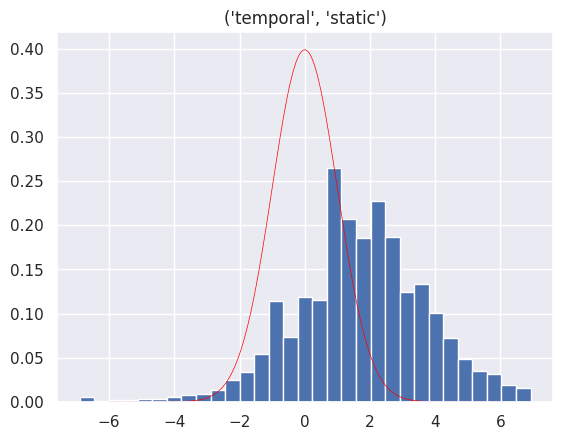

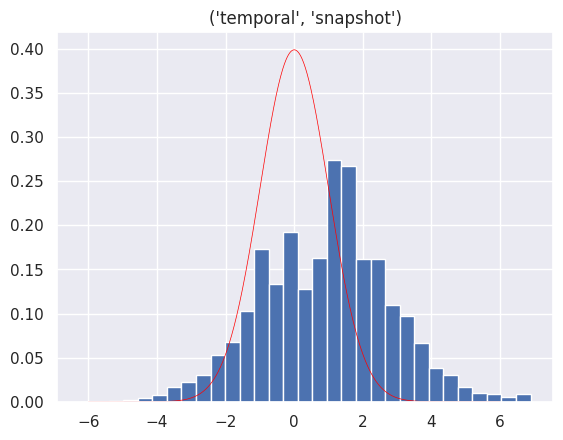

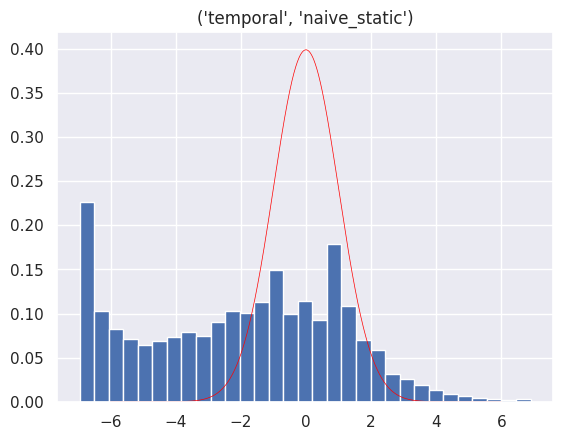

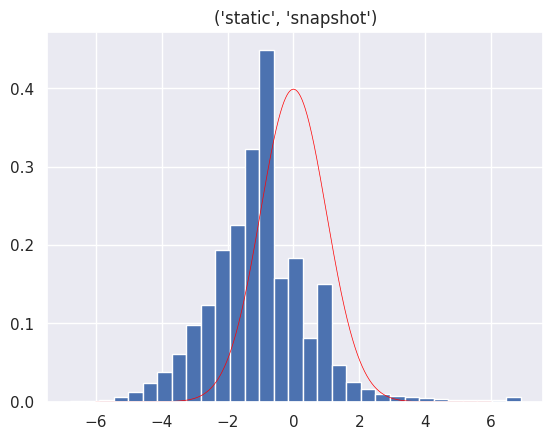

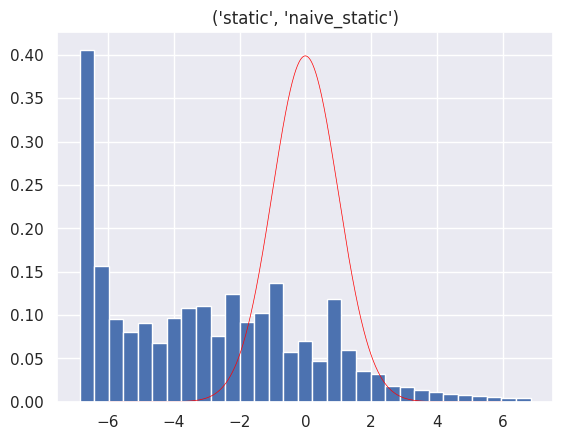

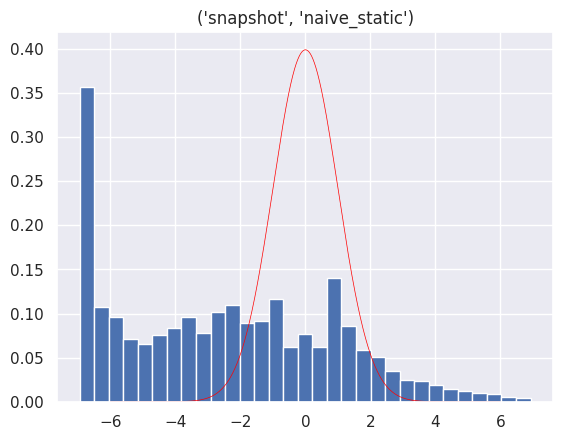

In [72]:
xzs = np.linspace(-6, 6, 1001)
for bit in (
    itertools.combinations(processed_results.keys(), 2)
):
    plt.figure()
    plt.title(bit)
    plt.hist(comparative_results[bit].select('statistic').to_series().to_numpy(), bins=31, density=True)
    plt.plot(xzs, stats.norm(0, 1).pdf(xzs), color='red', lw=0.5)

In [73]:
for k, v in comparative_results.items():
    z = stats.ks_1samp(v.select('statistic').filter(pl.col('statistic').is_finite()).to_series().to_numpy(), stats.norm(0, 1).cdf)
    print(k, z)

('static', 'snapshot') KstestResult(statistic=0.46498336448878774, pvalue=0.0, statistic_location=-1.0, statistic_sign=1)
('snapshot', 'static') KstestResult(statistic=0.46498336448878774, pvalue=0.0, statistic_location=1.0, statistic_sign=-1)
('static', 'naive_static') KstestResult(statistic=0.620302495608305, pvalue=0.0, statistic_location=-1.432579991631722, statistic_sign=1)
('naive_static', 'static') KstestResult(statistic=0.620302495608305, pvalue=0.0, statistic_location=1.432579991631722, statistic_sign=-1)
('temporal', 'static') KstestResult(statistic=0.5516676591568288, pvalue=0.0, statistic_location=1.0, statistic_sign=-1)
('static', 'temporal') KstestResult(statistic=0.5516676591568287, pvalue=0.0, statistic_location=-1.0, statistic_sign=1)
('temporal', 'snapshot') KstestResult(statistic=0.370464025426518, pvalue=0.0, statistic_location=0.9999864174357721, statistic_sign=-1)
('snapshot', 'temporal') KstestResult(statistic=0.370464025426518, pvalue=0.0, statistic_location=-0.